Epoch [1/5], Batch [30/341], Loss: 0.4727
Epoch [1/5], Batch [40/341], Loss: 0.3384
Epoch [1/5], Batch [50/341], Loss: 0.1919
Epoch [1/5], Batch [70/341], Loss: 0.0441
Epoch [1/5], Batch [80/341], Loss: 0.0046
Epoch [1/5], Batch [110/341], Loss: 0.0002
Epoch [1/5], Batch [120/341], Loss: 0.0002
Epoch [1/5], Batch [130/341], Loss: 0.0000
Epoch [1/5], Batch [160/341], Loss: 0.0001
Epoch [1/5], Batch [180/341], Loss: 0.0000
Epoch [1/5], Batch [220/341], Loss: 0.0000
Epoch [1/5], Batch [250/341], Loss: 0.0000
Epoch [1/5], Batch [260/341], Loss: 0.0000
Epoch [1/5], Batch [290/341], Loss: 0.0000
Epoch [1/5], Batch [310/341], Loss: 0.0000
Epoch [1/5], Batch [330/341], Loss: 0.0000
Epoch [1/5] - Train Loss: 0.0795, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
Epoch [2/5], Batch [30/341], Loss: 0.0000
Epoch [2/5], Batch [60/341], Loss: 0.0000
Epoch [2/5], Batch [80/341], Loss: 0.0000
Epoch [2/5], Batch [120/341], Loss: 0.0000
Epoch [2/5], Batch [150/341], Loss: 0.0000
Epoch [2/5], Bat

<ipython-input-10-ae90d754e1b7>:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))


Test Accuracy: 100.00%


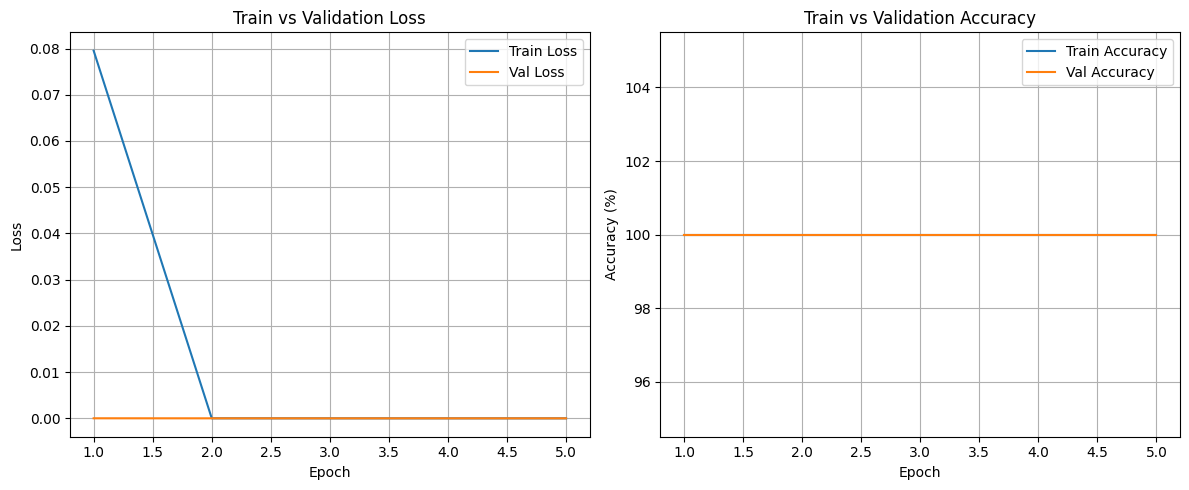

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch.cuda.amp as amp
import matplotlib.pyplot as plt
from torch_geometric.data import Data
class LIDCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        for patient in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient)
            for nodule in os.listdir(patient_path):
                nodule_path = os.path.join(patient_path, nodule)
                images_path = os.path.join(nodule_path, "images")
                slices = sorted(os.listdir(images_path))
                for slice_name in slices:
                    img_path = os.path.join(images_path, slice_name)
                    mask_paths = [os.path.join(nodule_path, f"mask-{i}", slice_name) for i in range(4)]
                    masks = []
                    for m in mask_paths:
                        if os.path.exists(m):
                            mask = np.array(Image.open(m).resize((224, 224), Image.NEAREST)) > 0
                        else:
                            mask = np.zeros((224, 224), dtype=bool)
                        masks.append(mask)
                    mask_sum = sum(m.sum() for m in masks)
                    label = 1 if mask_sum > 0 else -1
                    self.samples.append((img_path, label, patient, nodule, slice_name, masks))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, patient, nodule, slice_name, masks = self.samples[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label, patient, nodule, slice_name, masks

# collate_fn
def custom_collate_fn(batch):
    images, labels, patients, nodules, slices, masks = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    patients = list(patients)
    nodules = list(nodules)
    slices = list(slices)
    masks = list(masks)
    return images, labels, patients, nodules, slices, masks

# MVRGT模型
class MVRGT(nn.Module):
    def __init__(self, in_dim=50176, hidden_dim=128, num_classes=2, num_layers=3):
        super(MVRGT, self).__init__()
        self.pool4 = nn.AvgPool2d(4)
        self.pool8 = nn.AvgPool2d(8)
        self.pool16 = nn.AvgPool2d(16)
        self.fc4 = nn.Linear(3136, hidden_dim)
        self.fc8 = nn.Linear(784, hidden_dim)
        self.fc16 = nn.Linear(196, hidden_dim)
        self.fusion = nn.Linear(hidden_dim * 3, hidden_dim)
        
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'W': nn.Linear(hidden_dim, hidden_dim),
                'R_space': nn.Linear(hidden_dim, hidden_dim),
                'R_semantic': nn.Linear(hidden_dim, hidden_dim),
                'R_consistency': nn.Linear(hidden_dim, hidden_dim),
                'G': nn.Linear(hidden_dim, hidden_dim)
            }) for _ in range(num_layers)
        ])
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.edge_type_map = {'space': 0, 'semantic': 1, 'consistency': 2}
        
    def forward(self, x, edge_index, edge_type):
        x4 = self.pool4(x).view(x.size(0), -1)
        x8 = self.pool8(x).view(x.size(0), -1)
        x16 = self.pool16(x).view(x.size(0), -1)
        f4 = F.relu(self.fc4(x4))
        f8 = F.relu(self.fc8(x8))
        f16 = F.relu(self.fc16(x16))
        h = F.relu(self.fusion(torch.cat([f4, f8, f16], dim=-1)))
        
        for layer in self.layers:
            h_prime = F.relu(layer['W'](h))
            h_agg = torch.zeros_like(h)
            for etype, R in [('space', layer['R_space']), ('semantic', layer['R_semantic']), 
                            ('consistency', layer['R_consistency'])]:
                etype_idx = self.edge_type_map[etype]
                mask = edge_type == etype_idx
                if mask.sum() > 0:
                    src, dst = edge_index[:, mask]
                    h_agg.index_add_(0, dst, R(h_prime[src]))
            global_signal = layer['G'](h_prime.mean(dim=0, keepdim=True))
            h = h_prime + h_agg + global_signal
        
        out = self.classifier(h)
        return out

# 图构建与动态优化
def build_graph(data_batch, k=5):
    images, labels, patients, nodules, slices, masks = data_batch
    if len(images) != len(masks):
        return None, None
    
    features = images.view(len(images), -1)
    edge_index = []
    edge_type = []
    
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            if patients[i] != patients[j]:
                continue
            try:
                slice_i = int(slices[i].split('-')[1].split('.')[0])
                slice_j = int(slices[j].split('-')[1].split('.')[0])
                if abs(slice_i - slice_j) <= 1:
                    edge_index.append([i, j])
                    edge_index.append([j, i])
                    edge_type.extend(['space', 'space'])
            except (IndexError, ValueError):
                continue
            sim = F.cosine_similarity(features[i:i+1], features[j:j+1]).item()
            if sim > 0.8:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_type.extend(['semantic', 'semantic'])
            if i < len(masks) and j < len(masks) and len(masks[i]) == 4 and len(masks[j]) == 4:
                dice = np.mean([2 * (m1 & m2).sum() / (m1.sum() + m2.sum() + 1e-6) 
                               for m1, m2 in zip(masks[i], masks[j])])
                if dice > 0.8:
                    edge_index.append([i, j])
                    edge_index.append([j, i])
                    edge_type.extend(['consistency', 'consistency'])
    
    if not edge_index:
        return None, None
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor([{'space': 0, 'semantic': 1, 'consistency': 2}[t] for t in edge_type])
    return edge_index, edge_type

# 数据加载
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

root_dir = "/kaggle/input/lidcidri/LIDC-IDRI-slices"
dataset = LIDCDataset(root_dir, transform=transform)

train_idx, temp_idx = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, collate_fn=custom_collate_fn)

# 训练
device = torch.device("cuda")
model = MVRGT().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 5
best_acc = 0.0
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0
    batch_count = 0
    
    for batch_idx, batch in enumerate(train_loader):
        images, labels, patients, nodules, slices, masks = batch
        images, labels = images.to(device), labels.to(device)
        
        edge_index, edge_type = build_graph(batch)
        if edge_index is None:
            continue
        
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images, edge_index.to(device), edge_type.to(device))
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_train_loss += loss.item()
        batch_count += 1
        
        # 计算训练准确率
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -1
        train_total += mask.sum().item()
        train_correct += (predicted[mask] == labels[mask]).sum().item()
        
        if (batch_idx + 1) % 10 == 0:  # 每10个批次打印一次
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    epoch_train_loss = running_train_loss / batch_count if batch_count > 0 else 0
    epoch_train_acc = 100 * train_correct / train_total if train_total > 0 else 0
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    

    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_batch_count = 0
    
    with torch.no_grad():
        for batch in val_loader:
            images, labels, patients, nodules, slices, masks = batch
            images, labels = images.to(device), labels.to(device)
            edge_index, edge_type = build_graph(batch)
            if edge_index is None:
                continue
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images, edge_index.to(device), edge_type.to(device))
                loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            val_batch_count += 1
            
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -1
            val_total += mask.sum().item()
            val_correct += (predicted[mask] == labels[mask]).sum().item()
    
    epoch_val_loss = running_val_loss / val_batch_count if val_batch_count > 0 else 0
    epoch_val_acc = 100 * val_correct / val_total if val_total > 0 else 0
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    

    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    
    scheduler.step()


model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels, patients, nodules, slices, masks = batch
        images, labels = images.to(device), labels.to(device)
        edge_index, edge_type = build_graph(batch)
        if edge_index is None:
            continue
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images, edge_index.to(device), edge_type.to(device))
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -1
        test_total += mask.sum().item()
        test_correct += (predicted[mask] == labels[mask]).sum().item()

test_acc = 100 * test_correct / test_total if test_total > 0 else 0
print(f"Test Accuracy: {test_acc:.2f}%")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()